In [6]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

#自动微分对于实现机器学习算法（例如，用于训练神经网络的反向传播）非常有用。
#在本指南中，您将探索使用 TensorFlow 计算梯度的方法，尤其是在 Eager Execution 中。

In [7]:
### 1.3 自动微分 
## 计算梯度
#要实现自动微分，TensorFlow 需要记住在前向传递过程中哪些运算以何种顺序发生。随后，在后向传递期间，TensorFlow 以相反的顺序遍历此运算列表来计算梯度。 

### 1.3.1 梯度带
# TensorFlow 为自动微分提供了 tf.GradientTape API；即计算某个计算相对于某些输入（通常是 tf.Variable）的梯度。
# TensorFlow 会将在 tf.GradientTape 上下文内执行的相关运算“记录”到“条带”上。TensorFlow 随后会该使用条带通过反向模式微分计算“记录的”计算的梯度。
x = tf.Variable(3.0)
with tf.GradientTape() as tape :
    y = x**2

In [8]:
# 记录一些运算后，使用 GradientTape.gradient(target, sources) 计算某个目标（通常是损失）相对于某个源（通常是模型变量）的梯度。

# dy = 2x * dx
dy_dx = tape.gradient(y,x)
dy_dx.numpy()

6.0

In [12]:
# 上方示例使用标量，但是 tf.GradientTape 在任何张量上都可以轻松运行：
w = tf.Variable(tf.random.normal((3,2),name='w'))
b = tf.Variable(tf.zeros(2,dtype=tf.float32),name='b')
x = [[1.,2.,3.]]

with tf.GradientTape(persistent=True) as tape:  # @ 运算符 - 在 TensorFlow 中用于表示矩阵乘法。
    y = x @ w + b
    loss = tf.reduce_mean(y**2)

In [13]:
# 要获得 loss 相对于两个变量的梯度，可以将这两个变量同时作为 gradient 方法的源传递。
[dl_dw, dl_db] = tape.gradient(loss, [w,b])
w

<tf.Variable 'Variable:0' shape=(3, 2) dtype=float32, numpy=
array([[ 0.12206576, -0.49325025],
       [-0.00622404,  2.1378167 ],
       [-0.725695  ,  1.735126  ]], dtype=float32)>

In [14]:
dl_dw

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[-2.0674675,  8.987761 ],
       [-4.134935 , 17.975521 ],
       [-6.202402 , 26.963282 ]], dtype=float32)>

In [15]:
dl_db

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-2.0674675,  8.987761 ], dtype=float32)>

In [17]:
### 1.3.2 相对于模型的梯度
#通常将 tf.Variables 收集到 tf.Module 或其子类之一（layers.Layer、keras.Model）中，用于设置检查点和导出。
#在大多数情况下，需要计算相对于模型的可训练变量的梯度。 由于 tf.Module 的所有子类都在 Module.trainable_variables 属性中聚合其变量，
#  您可以用几行代码计算这些梯度：
layer = tf.keras.layers.Dense(2, activation='relu')
x = tf.constant([[1.,2.,3.]])

with tf.GradientTape() as tape:
    #Forward pass
    y = layer(x)
    loss = tf.reduce_mean(y**2)

#Calculate gradients with respect to every trainable variable
grad = tape.gradient(loss, layer.trainable_variables)

for var, g in zip(layer.trainable_variables, grad):
    print(f'{var.name}, shape: {g.shape}')



dense_1/kernel:0, shape: (3, 2)
dense_1/bias:0, shape: (2,)


In [19]:
layer.trainable_variables  # tf.keras.layers.Dense() ，参数use_bias该层是否使用偏置向量。默认为 True。
                           #参数kernel_initializer和bias_initializer，默认的权重初始化方法。

[<tf.Variable 'dense_1/kernel:0' shape=(3, 2) dtype=float32, numpy=
 array([[-0.6773174 , -0.08947396],
        [ 1.0192924 ,  0.96130705],
        [-0.8942217 ,  0.9965174 ]], dtype=float32)>,
 <tf.Variable 'dense_1/bias:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>]

In [21]:
grad

[<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
 array([[ 0.       ,  4.8226924],
        [ 0.       ,  9.645385 ],
        [ 0.       , 14.468077 ]], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.       , 4.8226924], dtype=float32)>]

In [22]:
### 1.3.3 控制梯度带监视的内容

#默认行为是在访问可训练 tf.Variable 后记录所有运算。原因如下：

#条带需要知道在前向传递中记录哪些运算，以计算后向传递中的梯度。
#梯度带包含对中间输出的引用，因此应避免记录不必要的操作。
#最常见用例涉及计算损失相对于模型的所有可训练变量的梯度。
#以下示例无法计算梯度，因为默认情况下 tf.Tensor 未被“监视”，并且 tf.Variable 不可训练：

# A trainable variable
x0 = tf.Variable(3.0, name='x0')
# Not trainable
x1 = tf.Variable(3.0, name='x1', trainable=False)
# Not a Variable: A variable + tensor returns a tensor.
x2 = tf.Variable(2.0, name='x2') + 1.0
# Not a variable
x3 = tf.constant(3.0, name='x3')

with tf.GradientTape() as tape:
  y = (x0**2) + (x1**2) + (x2**2)

grad = tape.gradient(y, [x0, x1, x2, x3]) #默认情况下 tf.Tensor 未被“监视”，并且 tf.Variable 不可训练

for g in grad:
  print(g)


tf.Tensor(6.0, shape=(), dtype=float32)
None
None
None


In [24]:
#您可以使用 GradientTape.watched_variables 方法列出梯度带正在监视的变量：
[var.name for var in tape.watched_variables()]

['x0:0']

In [25]:
#tf.GradientTape 提供了钩子，让用户可以控制被监视或不被监视的内容。

#要记录相对于 tf.Tensor 的梯度，您需要调用 GradientTape.watch(x)：
x = tf.constant(3.0)
with tf.GradientTape() as tape:
    tape.watch(x)
    y = x**2

# dy = 2x * dx
dy_dx = tape.gradient(y, x)
print(dy_dx.numpy())  

6.0


In [31]:
#相反，要停用监视所有 tf.Variables 的默认行为，请在创建梯度带时设置 
#watch_accessed_variables=False。此计算使用两个变量，但仅连接其中一个变量的梯度：
x0 = tf.Variable(0.0)
x1 = tf.Variable(10.0)

with tf.GradientTape(watch_accessed_variables=False) as tape:
  tape.watch(x1)
  y0 = tf.math.sin(x0)
  y1 = tf.nn.softplus(x1)
  y = y0 + y1
  ys = tf.reduce_sum(y)

#由于 GradientTape.watch 未在 x0 上调用，未相对于它计算梯度：
# dys/dx1 = exp(x1) / (1 + exp(x1)) = sigmoid(x1)
grad = tape.gradient(ys, {'x0': x0, 'x1': x1})   #输入数组返回数组，输入字典返回字典

print('dy/dx0:', grad['x0'])
print('dy/dx1:', grad['x1'].numpy())

dy/dx0: None
dy/dx1: 0.9999546


In [32]:
### 1.3.4 中间结果
#您还可以请求输出相对于 tf.GradientTape 上下文中计算的中间值的梯度。

x = tf.constant(3.0)

with tf.GradientTape() as tape:
    tape.watch(x)
    y = x * x
    z = y * y
    
# Use the tape to compute the gradient of z with respect to the
# intermediate value y.
# dz_dy = 2 * y and y = x ** 2 = 9
print(tape.gradient(z, y).numpy())

18.0


In [35]:
#默认情况下，只要调用 GradientTape.gradient 方法，就会释放 GradientTape 保存的资源。要在同一计算中计算多个梯度，
#请创建一个 persistent=True 的梯度带。这样一来，当梯度带对象作为垃圾回收时，随着资源的释放，可以对 gradient 方法进行多次调用。例如：
x = tf.constant([1, 3.0])
with tf.GradientTape(persistent=True) as tape:
  tape.watch(x)
  y = x * x
  z = y * y

print(tape.gradient(z, x).numpy())  # [4.0, 108.0] (4 * x**3 at x = [1.0, 3.0])
print(tape.gradient(y, x).numpy())  # [2.0, 6.0] (2 * x at x = [1.0, 3.0])

[  4. 108.]
[2. 6.]


In [36]:
### 1.3.5 非标量目标的梯度
#梯度从根本上说是对标量的运算。
#在TensorFlow中，标量是一个零维的向量，也就是说它只有一个元素。非标量是一个多维的向量，也就是说它有多个元素。
x = tf.Variable(2.0)
with tf.GradientTape(persistent=True) as tape:
  y0 = x**2
  y1 = 1 / x

print(tape.gradient(y0, x).numpy())
print(tape.gradient(y1, x).numpy())

4.0
-0.25


In [37]:
#因此，如果需要多个目标的梯度，则每个源的结果为：
#  目标总和的梯度，或等效
#  每个目标的梯度总和。
x = tf.Variable(2.0)
with tf.GradientTape() as tape:
  y0 = x**2
  y1 = 1 / x

print(tape.gradient({'y0': y0, 'y1': y1}, x).numpy()) 

3.75


In [38]:
#类似地，如果目标不是标量，则计算总和的梯度：
x = tf.Variable(2.)

with tf.GradientTape() as tape:
  y = x * [3., 4.]

print(tape.gradient(y, x).numpy())  

#这样一来，就可以轻松获取损失集合总和的梯度，或者逐元素损失计算总和的梯度。
#补充：一个batch内，有多条样本，每个样本可以求的一个dy_dx，多个y的梯度和作为这个batch的梯度。

7.0


In [39]:
#如果每个条目都需要单独的梯度，请参阅雅可比矩阵。

#在某些情况下，您可以跳过雅可比矩阵。对于逐元素计算，总和的梯度给出了每个元素相对于其输入元素的导数，因为每个元素都是独立的：
x = tf.linspace(-10.0, 10.0, 200+1)

with tf.GradientTape() as tape:
  tape.watch(x)
  y = tf.nn.sigmoid(x)

dy_dx = tape.gradient(y, x)

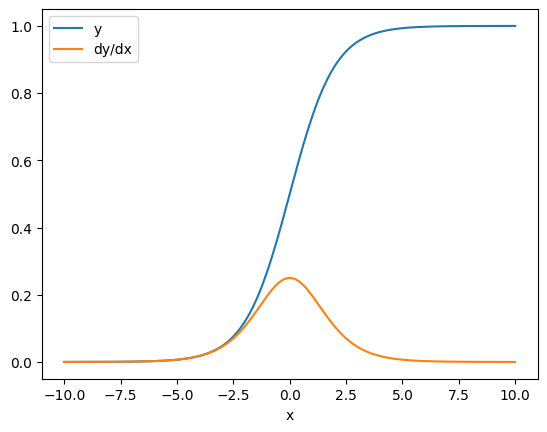

In [42]:
plt.plot(x, y, label='y')
plt.plot(x, dy_dx, label='dy/dx')
plt.legend()
_ = plt.xlabel('x')

In [43]:
### 1.3.6 控制流
#在执行运算时，由于梯度带会记录这些运算，因此会自然地处理 Python 控制流（例如 if 和 while 语句）。
#此处，if 的每个分支上使用不同变量。梯度仅连接到使用的变量：
x = tf.constant(1.0)

v0 = tf.Variable(2.0)
v1 = tf.Variable(2.0)

with tf.GradientTape(persistent=True) as tape:
  tape.watch(x)
  if x > 0.0:
    result = v0
  else:
    result = v1**2 

dv0, dv1 = tape.gradient(result, [v0, v1])

print(dv0)
print(dv1)

tf.Tensor(1.0, shape=(), dtype=float32)
None


In [44]:
#注意，控制语句本身不可微分，因此对基于梯度的优化器不可见。

#根据上面示例中 x 的值，梯度带将记录 result = v0 或 result = v1**2。 相对于 x 的梯度始终为 None。
dx = tape.gradient(result, x)

print(dx)


None


In [45]:
### 1.3.7 gradient 返回 None 的情况
#当目标未连接到源时，gradient 将返回 None
x = tf.Variable(2.)
y = tf.Variable(3.)

with tf.GradientTape() as tape:
  z = y * y
print(tape.gradient(z, x))

None


In [46]:
#此处 z 显然未连接到 x，但可以通过几种不太明显的方式将梯度断开。

##1. 使用张量替换变量
#在控制梯度带监视内容部分中，梯度带会自动监视 tf.Variable，但不会监视 tf.Tensor。
#一个常见错误是无意中将 tf.Variable 替换为 tf.Tensor，而不使用 Variable.assign 更新 tf.Variable。见下例：
x = tf.Variable(2.0)

for epoch in range(2):
  with tf.GradientTape() as tape:
    y = x+1

  print(type(x).__name__, ":", tape.gradient(y, x))
  x = x + 1   # This should be `x.assign_add(1)`

ResourceVariable : tf.Tensor(1.0, shape=(), dtype=float32)
EagerTensor : None


In [50]:
##2.在 TensorFlow 之外进行了计算
#如果计算退出 TensorFlow，梯度带将无法记录梯度路径。例如：
x = tf.Variable([[1.0, 2.0],
                 [3.0, 4.0]], dtype=tf.float32)

with tf.GradientTape() as tape:
  x2 = x**2

  # This step is calculated with NumPy
  y = np.mean(x2, axis=0)

  # Like most ops, reduce_mean will cast the NumPy array to a constant tensor
  # using `tf.convert_to_tensor`.
  y = tf.reduce_mean(y, axis=0)

print(tape.gradient(y, x))

None


In [51]:
##3.通过整数或字符串获取梯度
#整数和字符串不可微分。如果计算路径使用这些数据类型，则不会出现梯度。
#谁也不会期望字符串是可微分的，但是如果不指定 dtype，很容易意外创建一个 int 常量或变量。
x = tf.constant(10)

with tf.GradientTape() as g:
  g.watch(x)
  y = x * x

print(g.gradient(y, x))

#TensorFlow 不会在类型之间自动进行转换，因此，在实践中，您经常会遇到类型错误而不是缺少梯度。

None


In [55]:
##4. 通过有状态对象获取梯度
#状态会停止梯度。从有状态对象读取时，梯度带只能观察当前状态，而不能观察导致该状态的历史记录。
#tf.Tensor 不可变。张量创建后就不能更改。它有一个值，但没有状态。目前讨论的所有运算也都无状态：tf.matmul 的输出只取决于它的输入。
#tf.Variable 具有内部状态，即它的值。使用变量时，会读取状态。计算相对于变量的梯度是正常操作，但是变量的状态会阻止梯度计算进一步向后移动。 例如：
x0 = tf.Variable(3.0)
x1 = tf.Variable(0.0)

with tf.GradientTape() as tape:
  # Update x1 = x1 + x0.
  x1.assign_add(x0)
  # The tape starts recording from x1.
  y = x1**2   # y = (x1 + x0)**2

# This doesn't work.
print(tape.gradient(y, x0))   #dy/dx0 = 2*(x1 + x0)

#类似地，tf.data.Dataset 迭代器和 tf.queue 也有状态，会停止经过它们的张量上的所有梯度。

tf.Tensor(6.0, shape=(), dtype=float32)


In [56]:
### 1.3.8 未注册梯度
#某些 tf.Operation 被注册为不可微分，将返回 None。还有一些则未注册梯度。
#tf.raw_ops 页面显示了哪些低级运算已经注册梯度。
#如果您试图通过一个没有注册梯度的浮点运算获取梯度，梯度带将抛出错误，而不是直接返回 None。这样一来，您可以了解某个环节出现问题。
#例如，tf.image.adjust_contrast 函数封装了 raw_ops.AdjustContrastv2，此运算可能具有梯度，但未实现该梯度：
image = tf.Variable([[[0.5, 0.0, 0.0]]])
delta = tf.Variable(0.1)

with tf.GradientTape() as tape:
  new_image = tf.image.adjust_contrast(image, delta)

try:
  print(tape.gradient(new_image, [image, delta]))
  assert False   # This should not happen.
except LookupError as e:
  print(f'{type(e).__name__}: {e}')

#如果需要通过此运算进行微分，则需要实现梯度并注册该梯度（使用 tf.RegisterGradient），或者使用其他运算重新实现该函数。

LookupError: gradient registry has no entry for: AdjustContrastv2


In [59]:
### 1.3.9 零而不是 None
#在某些情况下，对于未连接的梯度，得到 0 而不是 None 会比较方便。您可以使用 unconnected_gradients 参数来决定具有未连接的梯度时返回的内容：
x = tf.Variable([2.,2.])
y = tf.Variable(3.)

with tf.GradientTape() as tape:
    z = y**2
tape.gradient(z,x,unconnected_gradients=tf.UnconnectedGradients.ZERO)


<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 0.], dtype=float32)>